In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/67349 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteI936JK/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/872 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteI936JK/glue-validation.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/1821 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteI936JK/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [3]:
info

tfds.core.DatasetInfo(
    name='glue',
    full_name='glue/sst2/2.0.0',
    description="""
    GLUE, the General Language Understanding Evaluation benchmark
    (https://gluebenchmark.com/) is a collection of resources for training,
    evaluating, and analyzing natural language understanding systems.
    """,
    config_description="""
    The Stanford Sentiment Treebank consists of sentences from movie reviews and
    human annotations of their sentiment. The task is to predict the sentiment of a
    given sentence. We use the two-way (positive/negative) class split, and use only
    sentence-level labels.
    """,
    homepage='https://nlp.stanford.edu/sentiment/index.html',
    data_path=PosixGPath('/tmp/tmp5rqi7h2etfds'),
    file_format=tfrecord,
    download_size=7.09 MiB,
    dataset_size=7.22 MiB,
    features=FeaturesDict({
        'idx': int32,
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'sentence': Text(shape=(), dtype=string),
    }),
    s

In [3]:
train_ds, valid_ds = dataset['train'], dataset['validation']
train_ds

<PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [4]:
for example in train_ds.take(2):  
  review, label = example["sentence"], example["label"]
  print("Review:", review.numpy())
  print("Label: %d \n" % label.numpy())

Review: b'for the uninitiated plays better on video with the sound '
Label: 0 

Review: b'like a giant commercial for universal studios , where much of the action takes place '
Label: 0 



In [5]:
training_sentences = []
training_labels = []
for item in train_ds.take(10000):
  training_sentence, training_label = item["sentence"], item["label"]
  training_sentences.append(str(training_sentence.numpy()))
  training_labels.append(training_label.numpy())

In [6]:
validation_sentences = []
validation_labels = []
for item in valid_ds.take(-1):  
  review, label = item["sentence"], item["label"]
  validation_sentences.append(str(review.numpy()))
  validation_labels.append(label.numpy())

In [7]:
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)

In [8]:
vocab_size = 4000
max_length = 50
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(training_sentences, vocab_size, 
                                                                      max_subword_length=5)



In [9]:
def encode(sentences):
  encoded_sentences = []
  for i, sentence in enumerate(sentences):
    encoded_sentences.append(tokenizer.encode(sentence))
  padded_sequences = tf.keras.utils.pad_sequences(encoded_sentences, maxlen=max_length, 
                                                padding='post', truncating='post')
  return padded_sequences

In [10]:
training_seq = encode(training_sentences)
validation_seq = encode(validation_sentences)

In [11]:
embedding_dim = 16
num_epochs = 20

def compile_model(model):
  model.summary()
  history = model.fit(training_seq, training_labels, epochs=num_epochs, 
                      validation_data=(validation_seq, validation_labels))
  return history

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def predict_new_sentences(model, new_sentences, labels, maxlen=max_length):
  encoded_sentences = []
  for i, sentence in enumerate(new_sentences):
    encoded_sentences.append(tokenizer.encode(sentence))
  
  padded_sequences = tf.keras.utils.pad_sequences(encoded_sentences, maxlen=maxlen, 
                                                  padding='post', truncating='post')
  predictions = model.predict(padded_sequences)
  return predictions

def fit_model_and_show_results (model, new_sentences, labels):
  history = compile_model(model)
  plot_results(history)
  return predict_new_sentences(model, new_sentences, labels)

In [20]:
new_sentences = []
new_labels = []
for item in train_ds.skip(20000).take(1000):
  new_sentence, label = item["sentence"], item["label"]
  new_sentences.append(str(new_sentence.numpy()))
  new_labels.append(label.numpy())
new_labels = np.array(new_labels)

In [22]:
embedding_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])
embedding_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 19s 58ms/step - loss: 0.6818 - accuracy: 0.5583 - val_loss: 0.6878 - val_accuracy: 0.5401
Epoch 2/20
313/313 [==============================] - 7s 21ms/step - loss: 0.6647 - accuracy: 0.5933 - v

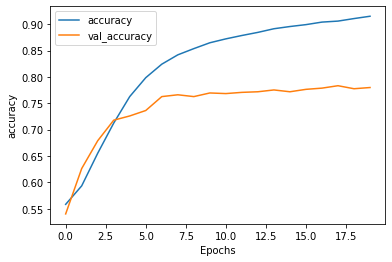

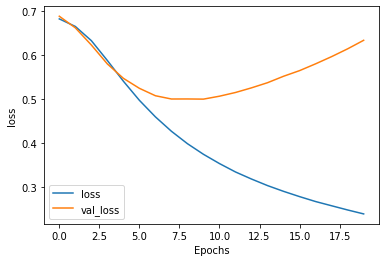

32/32 [==============================] - 0s 2ms/step


In [23]:
embedding_predictions = fit_model_and_show_results(embedding_model, new_sentences, new_labels)

In [25]:
mse = tf.keras.losses.MeanSquaredError()
mse(new_labels, embedding_predictions).numpy()

0.37773073

In [26]:
def fit_model_and_find_mse (model, new_sentences, labels):
  predictions = fit_model_and_show_results(model, new_sentences, labels)
  print(mse(new_labels, predictions).numpy())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d (Conv1D)             (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 33s 79ms/step - loss: 0.6909 - accuracy: 0.5348 - val_loss: 0.

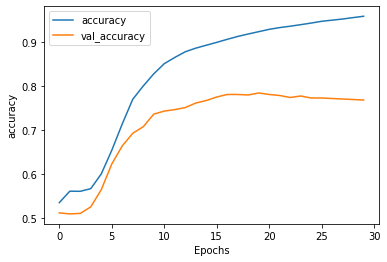

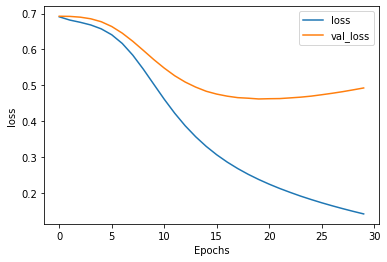

32/32 [==============================] - 0s 1ms/step
0.40608215


In [27]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_find_mse(model_cnn, new_sentences, new_labels)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 24s 59ms/step - loss: 0.6884 - accuracy: 0.5589 - val_loss: 0.6954 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 7s 24ms/step - loss: 0.6857 - accuracy: 0.5590 - v

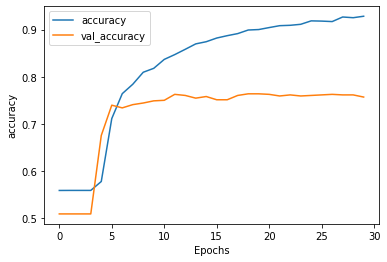

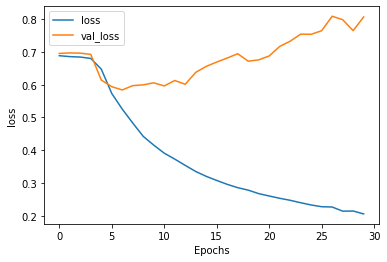

32/32 [==============================] - 1s 5ms/step
0.40457442


In [28]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00005
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_find_mse(model_gru, new_sentences, new_labels)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 22s 57ms/step - loss: 0.6922 - accuracy: 0.5245 - val_loss: 0.6928 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 5s 18ms/step - loss: 0.6876 - accuracy: 0.5590 - v

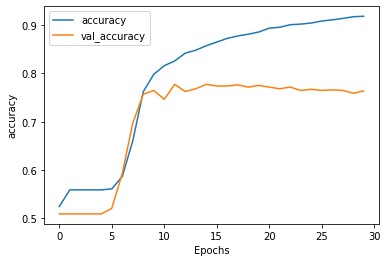

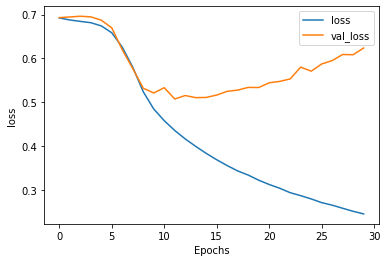

32/32 [==============================] - 1s 3ms/step
0.38270417


In [29]:
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_find_mse(model_bidi_lstm, new_sentences, new_labels)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================

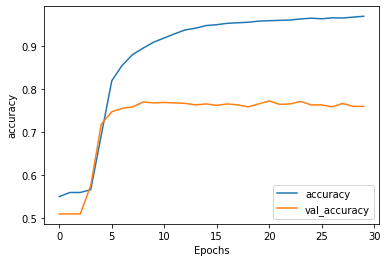

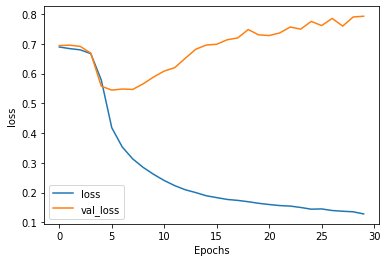

32/32 [==============================] - 2s 6ms/step
0.45821545


In [31]:
model_multi_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_multi_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_find_mse(model_multi_bidi_lstm, new_sentences, new_labels)